# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

<h1>Содержание<span class="tocSkip">

### Откройте файл с данными и изучите общую информацию. 

In [1]:
# импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# чтение данных
data = pd.read_csv('datasets/real_estate_data.csv', sep='\t')

data.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


По первым строкам видно, что данные содержат пропуски. Посмотрим общую информацию о датасете:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

***Описание данных***
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах (м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)
- `rooms` — число комнат
- `studio` — квартира-студия (Boolean)
- `total_area` — общая площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

In [4]:
total_length = len(data)
print(f'Всего {total_length} строк.')

Всего 23699 строк.


Построим гистограммы для всех столбцов:

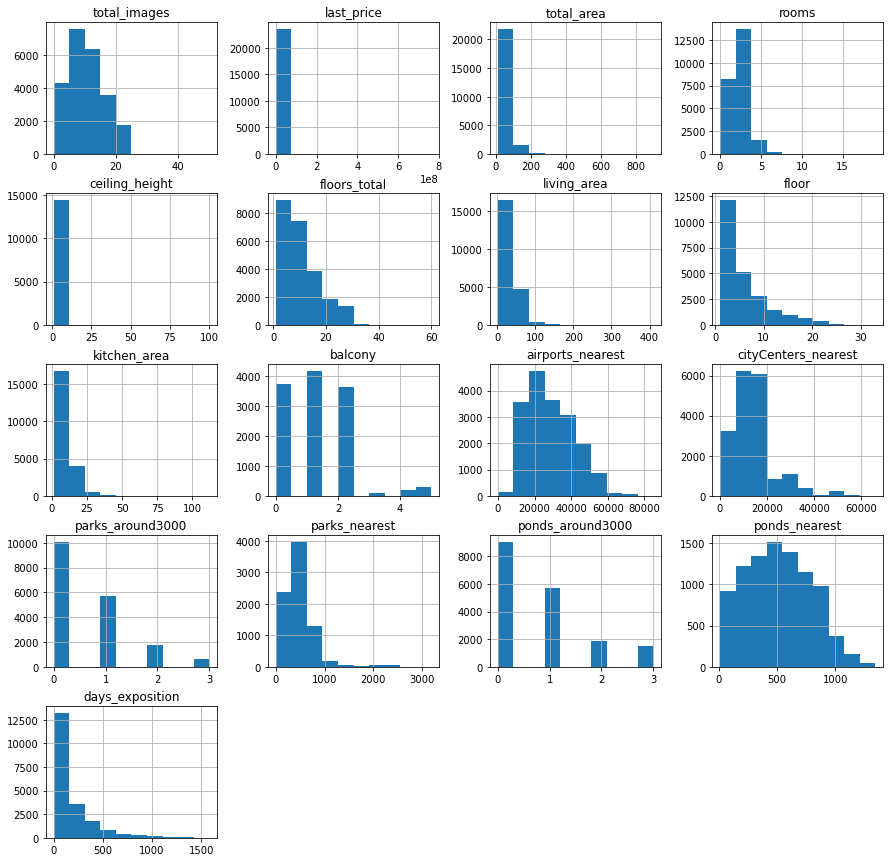

In [5]:
data.hist(figsize=(15, 15))
None

На всех гистограммах распределение похоже на распределение Пуассона, следовательно, данные не содержат больших проблем.

### Предобработка данных

Отметим потенциальные проблемы по каждому столбцу:

 * [x] `total_images` 
 * [x] `last_price`
 * [x] `total_area`
 * [ ] `first_day_exposition` -  <span style="color:#CD6155">*требуемый тип данных - datetime*</span>
 * [x] `rooms` 
 * [ ] `ceiling_height` -  <span style="color:#CD6155">*много пропущенных значений*</span>
 * [ ] `floors_total` -  <span style="color:#CD6155">*есть пропущенные значения, требуемый тип данных - int*</span>
 * [ ] `living_area` -  <span style="color:#CD6155">*есть пропущенные значения*</span>
 * [x] `floor` 
 * [ ] `is_apartment` -  <span style="color:#CD6155">*много пропущенных значений, требуемый тип данных - bool*</span>
 * [x] `studio`
 * [x] `open_plan` 
 * [ ] `kitchen_area` -  <span style="color:#CD6155">*есть пропущенные значения*</span>
 * [ ] `balcony`  -  <span style="color:#CD6155">*много пропущенных значений, требуемый тип данных - int*</span>
 * [ ] `locality_name` -  <span style="color:#CD6155">*есть пропущенные значения*</span>
 * [ ] `airports_nearest` -  <span style="color:#CD6155">*есть пропущенные значения*</span>
 * [ ] `cityCenters_nearest` -   <span style="color:#CD6155">*есть пропущенные значения*</span>
 * [ ] `parks_around3000` -  <span style="color:#CD6155">*есть пропущенные значения, требуемый тип данных - int*</span>
 * [ ] `parks_nearest` -  <span style="color:#CD6155">*много пропущенных значений*</span>
 * [ ] `ponds_around3000` -  <span style="color:#CD6155">*есть пропущенные значения, требуемый тип данных - int*</span>
 * [ ] `ponds_nearest` -  <span style="color:#CD6155">*много пропущенных значений*</span>
 * [ ] `days_exposition` -  <span style="color:#CD6155">*есть пропущенные значения, требуемый тип данных - int*</span>
 

#### Преобразование типов

 * `first_day_exposition` - дата
 * `floors_total` - количество этажей в доме целое
 * `balcony` - количество балконов целое
 * `parks_around3000`, `ponds_around3000` -  количество парков и водоемов целое
 * `days_exposition` -  количество дней целое

In [6]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

data['floors_total'] = data['floors_total'].astype('int', errors='ignore')

data['balcony'] = data['balcony'].astype('int', errors='ignore')

data['parks_around3000'] = data['parks_around3000'].astype('int', errors='ignore')
data['ponds_around3000'] = data['ponds_around3000'].astype('int', errors='ignore')

data['days_exposition'] = data['days_exposition'].astype('int', errors='ignore')

#### Поиск аномальных значений

Столбцы `total_images`, `last_price`, `total_area`,`rooms`, `floor`, `studio`, `open_plan` не имеют пропущенных значений. Проверим `total_images`, `rooms`, `floor`, `studio`, `open_plan` на наличие аномальных значений.

In [7]:
def info(column):
    if len(column.unique()) > 2:
        print(f'  Диапазон значений: {column.min()} - {column.max()}.')
    print('  Уникальные значения:', end=' ')
    print(*sorted(column.unique()), sep=', ')

for col in ['total_images', 'rooms', 'floor', 'studio', 'open_plan']:
    print(f"'{col}'",end=':\n')
    info(data[col])
    print()

'total_images':
  Диапазон значений: 0 - 50.
  Уникальные значения: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 39, 42, 50

'rooms':
  Диапазон значений: 0 - 19.
  Уникальные значения: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 19

'floor':
  Диапазон значений: 1 - 33.
  Уникальные значения: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33

'studio':
  Уникальные значения: False, True

'open_plan':
  Уникальные значения: False, True



Все значения выглядят нормально. Значения в столбцах `last_price` и `total_area` могут быть любыми. Проверим разброс значений:

In [8]:
for col in ['last_price', 'total_area']:
    print(f"'{col}'",end=':\n')
    print(f'  Диапазон значений: {data[col].min()} - {data[col].max()}.')
    print()

'last_price':
  Диапазон значений: 12190.0 - 763000000.0.

'total_area':
  Диапазон значений: 12.0 - 900.0.



Диапазоны не вызывают вопросов (согласно google, в Санкт-Петербурге есть, например, квартира 900 кв.м. и квартира за 800 млн). 

Перейдем к данным `ceiling_height`.

In [9]:
col = 'ceiling_height'
print(f'Диапазон значений: {data[col].min()} - {data[col].max()}.')

Диапазон значений: 1.0 - 100.0.


Присутствуют подозрительно большие значения:

In [10]:
print(*sorted(data.query('ceiling_height >= 10')['ceiling_height'].unique()), sep=', ')

10.3, 14.0, 20.0, 22.6, 24.0, 25.0, 26.0, 27.0, 27.5, 32.0, 100.0


Можно предположить, что была допущена ошибка при вводе данных, и реальная высота меньше в 10 раз. В России минимальная высота потолка - 2.4 м, поэтому значения свыше 24 заменим:

In [11]:
data.loc[data['ceiling_height'] >= 24, 'ceiling_height'] = data.loc[data['ceiling_height'] >= 24, 'ceiling_height'] / 10

#### Обработка пропусков

Перейдем к остальным данным. Во многих столбцах есть пропуски, но каждая строка содержит данные, полезные для исследований. Заполним пропуски по возможности.

***`ceiling_height`***. Для высоты потолка сложно выбрать некоторую характерную величину для заполнения пропусков. Оставим эти пропуски незаполненными.

***`floors_total`***. В столбце присутствуют пропуски:

In [12]:
data['floors_total'].isna().sum()

86

In [13]:
data[data['floors_total'].isna()].tail(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
22542,5,8500000.0,63.5,2017-05-24,2,2.8,NaN,NaN,3,NaN,...,NaN,NaN,Санкт-Петербург,51340.0,15363.0,0.0,NaN,1.0,853.0,512.0
22656,4,4574160.0,64.5,2017-04-02,2,NaN,NaN,31.70,20,NaN,...,14.40,0.0,Санкт-Петербург,22041.0,17369.0,0.0,NaN,1.0,374.0,127.0
22808,0,14569263.0,110.4,2016-11-20,3,NaN,NaN,45.38,6,NaN,...,23.42,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,260.0
23590,0,21187872.0,123.3,2017-04-25,3,NaN,NaN,50.40,18,NaN,...,23.60,0.0,Санкт-Петербург,19095.0,4529.0,0.0,NaN,0.0,NaN,104.0
23658,6,3063600.0,43.8,2016-11-28,1,2.7,NaN,14.00,8,NaN,...,15.50,2.0,Санкт-Петербург,8426.0,12082.0,2.0,24.0,1.0,271.0,246.0


Количество этажей в доме невозможно определить по другим параметрам. Также не наблюдается никакой зависимости между пропущенными данными. Оставим как есть.

***`living_area`***

In [14]:
def info(column):
    print('Всего пропусков:', column.isna().sum())
    print(f"Доля пропусков: {round(column.isna().sum() / total_length * 100)}%")
info(data['living_area'])

Всего пропусков: 1903
Доля пропусков: 8%


8% данных отсутствует. Для расчета пропущенных значений можно использовать общую площадь квартиры.  Заполним пропуcки следующим образом:
  1. Найдем долю жилой площади в для каждой квартиры - `living_area_rate`
  2. Заполним пропуски `living_area_rate` средним в зависимости от количества комнат
  3. Заполним пропуски `living_area` на произведение `total_area` на `living_area_rate`
  

In [15]:
data['living_area_rate'] = data['living_area'] / data['total_area']

for room_count in data['rooms'].unique():
    avg_rate = data.query('rooms == @room_count')['living_area_rate'].mean()
    data.loc[data['rooms'] == room_count, 'living_area_rate'] \
        = data.loc[data['rooms'] == room_count, 'living_area_rate'].fillna(avg_rate)

data.loc[data['living_area'].isna(), 'living_area'] = data.loc[data['living_area'].isna(),'total_area'] \
   * data.loc[data['living_area'].isna(),'living_area_rate']

data = data.drop('living_area_rate', axis=1)

***`is_apartment`***

In [16]:
info(data['is_apartment'])

Всего пропусков: 20924
Доля пропусков: 88%


Пропусков много. Апартаменты редки, поэтому, вероятно, эту графу не заполняют. Будем считать, что по умолчанию тип помещения - не апартаменты. Заполним пропуски значением *False*:

In [17]:
data['is_apartment'] = data['is_apartment'].fillna(False)

***`kitchen_area`***

In [18]:
info(data['kitchen_area'])

Всего пропусков: 2278
Доля пропусков: 10%


In [19]:
data['kitchen_area'].describe()

count    21421.000000
mean        10.569807
std          5.905438
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

<AxesSubplot:>

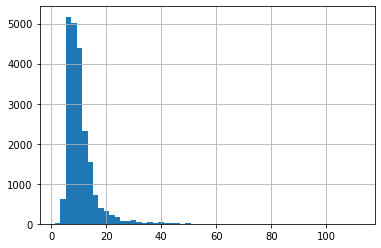

In [20]:
data['kitchen_area'].hist(bins=56)

Менее 6% кухонь имеют площадь более 20 кв.м. Проверим, влияет ли площадь квартиры на площадь кухни:

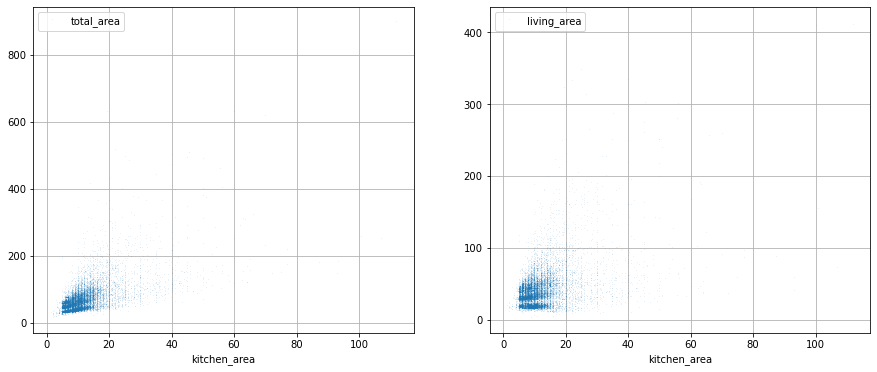

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figheight(6)
fig.set_figwidth(15)

data.plot(x='kitchen_area', y='total_area', style=',', grid=True, ax=ax[0], alpha=0.1)
data.plot(x='kitchen_area', y='living_area', style=',', grid=True, ax=ax[1], alpha=0.1)
None

Площадь кухни практически не зависит от площади квартиры. Причем разброс значений тоже небольшой. Заполним пропуски медианным значением площади:

In [22]:
avg_kitchen_area = data['kitchen_area'].median()
data['kitchen_area'] = data['kitchen_area'].fillna(avg_kitchen_area)

***`balcony`***

Логично предположить, что при отсутствии балкона данные не вносились. Заменим пропуски на 0:

In [23]:
data['balcony'] = data['balcony'].fillna(0)

***`locality_name`***

Невозможно восстановить, в каких местах были выставлены объявления. Замени пропуски значением *unknown*:

In [24]:
data['locality_name'] = data['locality_name'].fillna('unknown')

In [25]:
my_list = sorted(data['locality_name'].unique())
n = len(my_list)
for first, second, third in zip(my_list[:n//3], my_list[n//3:2*n//3], my_list[2*n//3:]):
    print(f'{first: <35}{second: <35}{third}')

unknown                            деревня Парицы                     поселок Цвелодубово
Бокситогорск                       деревня Пельгора                   поселок Цвылёво
Волосово                           деревня Пеники                     поселок городского типа Большая Ижора
Волхов                             деревня Пижма                      поселок городского типа Вырица
Всеволожск                         деревня Пикколово                  поселок городского типа Дружная Горка
Выборг                             деревня Пудомяги                   поселок городского типа Дубровка
Высоцк                             деревня Пустынка                   поселок городского типа Ефимовский
Гатчина                            деревня Пчева                      поселок городского типа Кондратьево
Зеленогорск                        деревня Рабитицы                   поселок городского типа Красный Бор
Ивангород                          деревня Разбегаево                 поселок городског

Основные дупликаты появляются за счет разного написания слов, обозначающие тип населенного пункта. Для удобства введем общепринятые сокращения.

In [26]:
def type_of_locality_abbr(locality_name): #функция ввода аббревиатур
    replacement_dictionary = {'городской поселок': 'пгт.', 
                              'городской посёлок': 'пгт.',
                              'поселок городского типа': 'пгт.', 
                              'посёлок городского типа': 'пгт.',
                              'коттеджный поселок': 'кп.',
                              'коттеджный посёлок': 'кп.',
                              'поселок': 'п.', 
                              'посёлок': 'п.',
                              'деревня': 'д.',
                              'садоводческое некоммерческое товарищество': 'снт.', 
                              'садовое товарищество': 'снт.', 
                              'село': 'с.'}
    new_name = locality_name
    for before, after in replacement_dictionary.items():
        new_name = new_name.replace(before, after)
    return new_name
        
data['locality_name'] = data['locality_name'].apply(type_of_locality_abbr)

In [27]:
my_list = sorted(data['locality_name'].unique())
n = len(my_list)
for first, second, third in zip(my_list[:n//3], my_list[n//3:2*n//3], my_list[2*n//3:]):
    print(f'{first: <35}{second: <35}{third}')

unknown                            д. Пельгора                        п. Петровское
Бокситогорск                       д. Пеники                          п. Платформа 69-й километр
Волосово                           д. Пижма                           п. Плодовое
Волхов                             д. Пикколово                       п. Плоское
Всеволожск                         д. Пудомяги                        п. Победа
Выборг                             д. Пустынка                        п. Поляны
Высоцк                             д. Пчева                           п. Понтонный
Гатчина                            д. Рабитицы                        п. Почап
Зеленогорск                        д. Разбегаево                      п. Починок
Ивангород                          д. Раздолье                        п. Пригородный
Каменногорск                       д. Разметелево                     п. Пудость
Кингисепп                          д. Рапполово                       п. Пушное
Кириши 

***Другие***

Картографические данные, а именно `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `parks_nearest`, `ponds_around3000`, `ponds_nearest`, невозможно восстановить. 

Данные после предварительной обработки:

In [28]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.000000,8,False,...,25.00,0.0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04,1,NaN,11.0,18.600000,1,False,...,11.00,2.0,п. Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20,2,NaN,5.0,34.300000,4,False,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24,3,NaN,14.0,99.422951,9,False,...,9.10,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.000000,13,False,...,41.00,0.0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10,1,NaN,12.0,14.400000,5,False,...,9.10,0.0,пгт. Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02,1,NaN,26.0,10.600000,6,False,...,14.40,1.0,п. Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18,2,NaN,24.0,41.476924,22,False,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23,1,NaN,27.0,15.430000,26,False,...,8.81,0.0,п. Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.600000,7,False,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        14504 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          23699 non-null  float64       
 13  balcony         

### Создание дополнительных столбцов

На основе имеющихся данных введем дополнительные столбцы:

- `price_per_square_meter` - цена одного квадратного метра
- `weekday_exposition` - день недели публикации объявления
- `month_exposition` - месяц публикации объявления
- `year_exposition` - год публикации объявления

In [30]:
# Цена квадратного метра
data['price_per_square_meter'] = data['last_price'] / data['total_area']

# День недели, в который было опубликовано объявление
data['weekday_exposition'] = data['first_day_exposition'].dt.weekday

# Месяц публикации
data['month_exposition'] = data['first_day_exposition'].dt.month

# Год публикации
data['year_exposition'] = data['first_day_exposition'].dt.year

Введем категоризацию в соответствии с этажом, на котором расположена квартира:
 - `первый`
 - `последний`
 - `другой`

In [31]:
def floor_category(row):
    floors_total = row['floors_total']
    floor = row['floor']
    if floor == 1:
        return 'первый'
    if floor == floors_total:
        return 'последний'
    if 1 < floor < floors_total:
        return 'другой'
      
data['floor_category'] = data.apply(floor_category, axis = 1)

Для удобства переведем расстояние до центра и до ближайшего аэропорта в км:

In [32]:
data['cityCenters_nearest'] = (data['cityCenters_nearest'] / 1000).round(0).astype('int', errors='ignore')
data['airports_nearest'] = (data['airports_nearest'] / 1000).astype('int', errors='ignore')

### Проведите исследовательский анализ данных

#### Исследование параметров объектов

##### Общая площадь

In [33]:
data['total_area'].describe()

count    23699.000000
mean        60.348651
std         35.654083
min         12.000000
25%         40.000000
50%         52.000000
75%         69.900000
max        900.000000
Name: total_area, dtype: float64

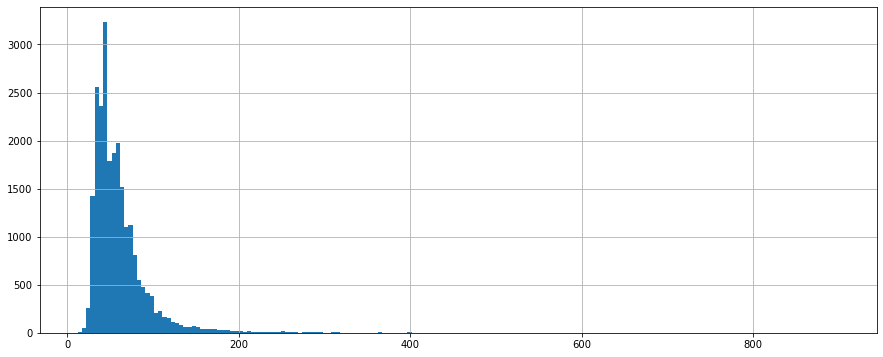

In [34]:
data['total_area'].hist(bins=180, figsize=(15, 6))
None

**Вывод:**

Средняя площадь квартир - 60 кв.м., медианная - 52 кв.м. Большая часть квартир имеет площадь от 20 до 100 кв.м. Затем наблюдается резкое уменьшение количества квартир.

##### Жилая площадь

In [35]:
data['living_area'].describe()

count    23699.000000
mean        34.666591
std         22.765091
min          2.000000
25%         18.764032
50%         30.000000
75%         42.300000
max        415.185969
Name: living_area, dtype: float64

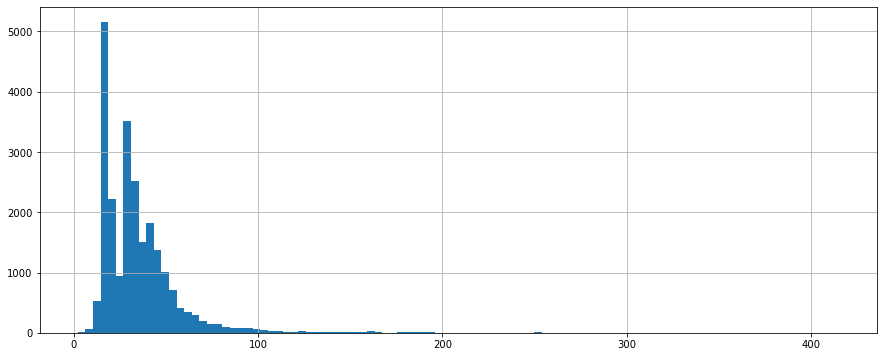

In [36]:
data['living_area'].hist(bins=100, figsize=(15, 6))
None

Присутствуют 2 пика. Посмотрим более подробно квартиры с жилой площадью до 100 кв.м.:

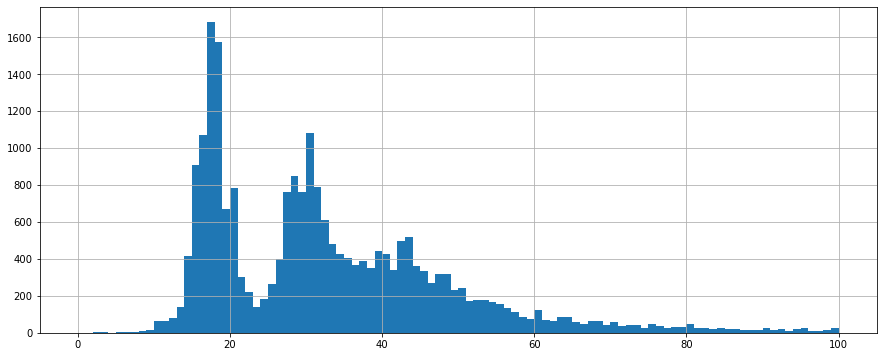

In [37]:
data['living_area'].hist(bins=100, range=(0,100), figsize=(15, 6))
None

Присутствуют даже 3 локальных пика: 17кв.м., 32 кв.м. и 44 кв.м. Предположительно эти пики возникают из-за разного распределения жилой площади в зависимости от количества комнат. Для проверки построим отдельно гистограммы для 1-комнатных, 2-комнатных и 3-комнатных квартир:

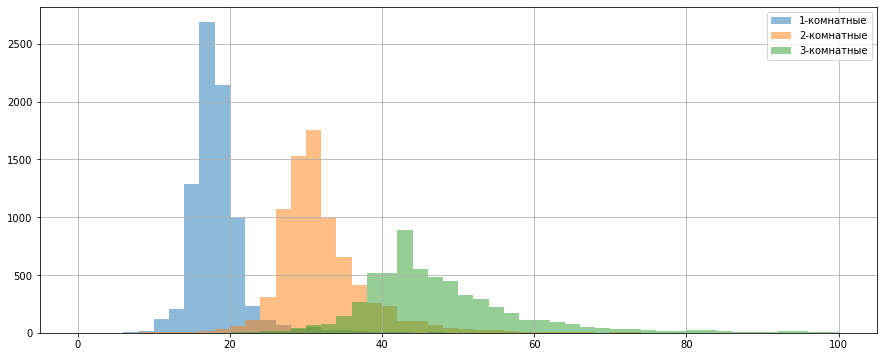

In [38]:
fig, ax = plt.subplots()
for room_count in range(1,4):
    data.loc[data['rooms'] == room_count, 'living_area'].hist(bins=50, range=(0,100), figsize=(15,6), alpha = 0.5)
ax.legend(['1-комнатные', '2-комнатные', '3-комнатные'])
None

In [39]:
for room_count in range(1,4):
    print('Средняя жилая площадь ' + str(room_count) + '-комнатных квартир:', 
          round(data.loc[data['rooms'] == room_count, 'living_area'].mean(), 1), 'кв.м.')

Средняя жилая площадь 1-комнатных квартир: 18.0 кв.м.
Средняя жилая площадь 2-комнатных квартир: 31.8 кв.м.
Средняя жилая площадь 3-комнатных квартир: 47.7 кв.м.


Пики на отдельных гистограммах совпадают с пиками на общей. В данных присутствуют квартиры и с другим количеством комнат, однако они не создают дополнительных пиков, так как их намного меньше.

**Вывод:**

Распределение жилой площади квартир отличается от распределения Пуассона, так как сильно зависит от количества комнат. Наибольшее влияние оказывают 1-3-комнатные квартиры, поскольку их намного больше, чем остальных. Пики находятся на ~17, ~32 и ~48 кв.м. для 1-комнатных, 2-комнатных и 3-комнатных квартир соответственно.

##### Площадь кухни

In [40]:
data['kitchen_area'].describe()

count    23699.000000
mean        10.428526
std          5.631126
min          1.300000
25%          7.400000
50%          9.100000
75%         11.440000
max        112.000000
Name: kitchen_area, dtype: float64

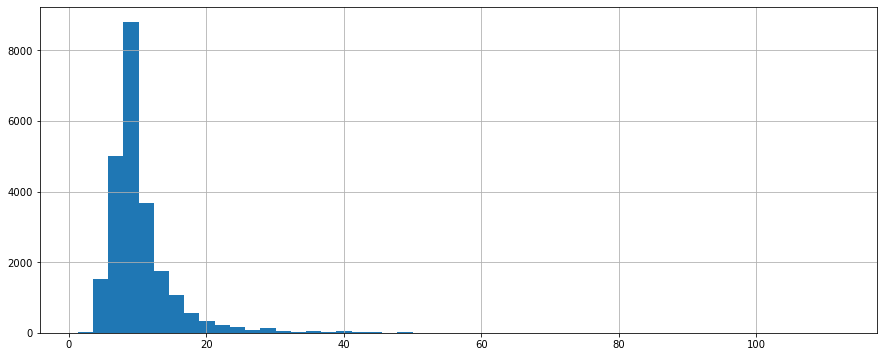

In [41]:
data['kitchen_area'].hist(bins=50, figsize=(15, 6))
None

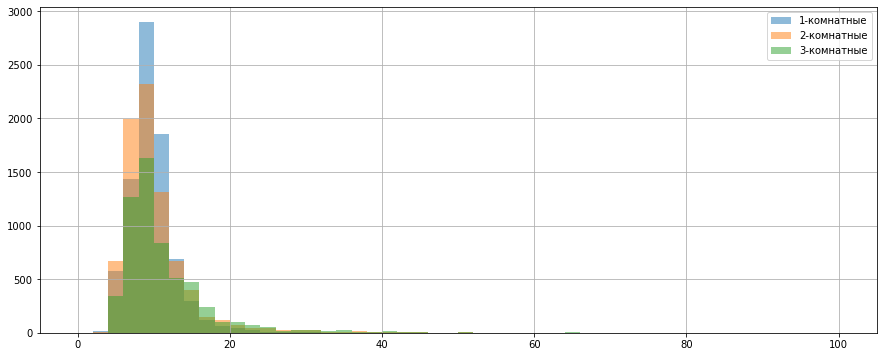

In [42]:
fig, ax = plt.subplots()
for room_count in range(1,4):
    data.loc[data['rooms'] == room_count, 'kitchen_area'].hist(bins=50, range=(0,100), figsize=(15,6), alpha = 0.5)
ax.legend(['1-комнатные', '2-комнатные', '3-комнатные'])
None

**Вывод:**

Размеры кухни мало зависят от других параметров квартир, в среднем площадь кухни равна 10 кв.м, и большая часть кухонь имеет площадь менее 20 кв.м.

##### Количество комнат

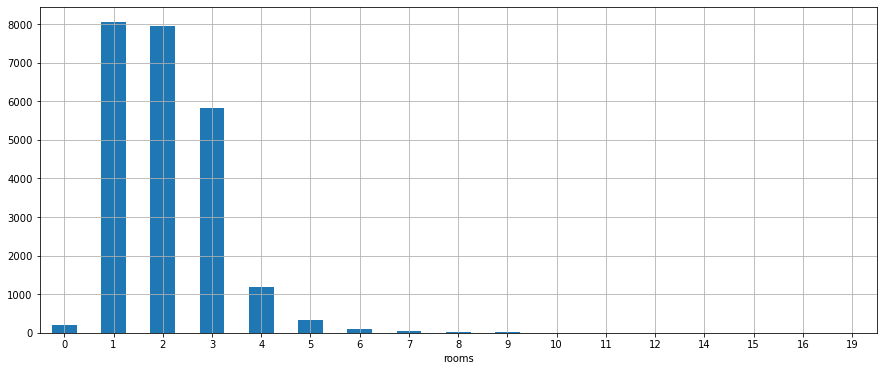

In [43]:
data.groupby('rooms')['last_price'].count().plot.bar(rot=0, grid=True, figsize=(15, 6))
None

**Вывод:**

Самые популярные квартиры - 1, 2 и 3-комнатные, они составляют более 90% от всех объектов. Квартир с количеством комнат более 7 практически нет, единичные случаи.

##### Выстота потолков

In [44]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.732251
std          0.387344
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         22.600000
Name: ceiling_height, dtype: float64

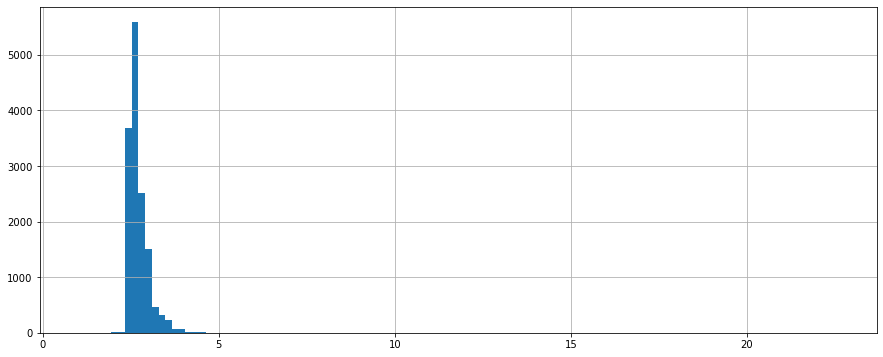

In [45]:
data['ceiling_height'].hist(bins=113, figsize=(15, 6))
None

Большая часть квартир имеет высоту потолков до 5 м. Рассмотрим подробнее этот промежуток:

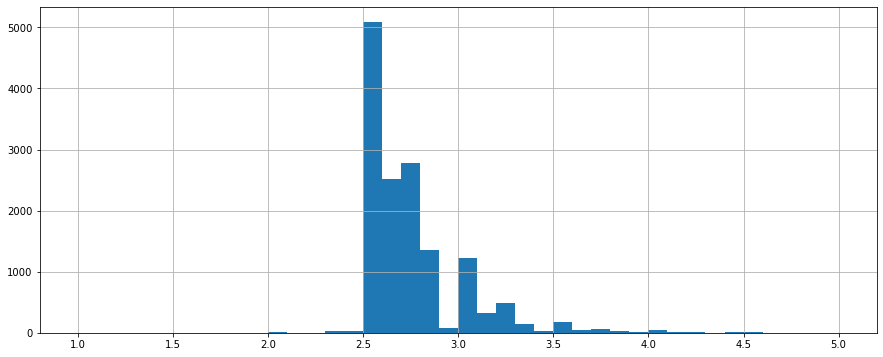

In [46]:
data.loc[data['ceiling_height'] <= 5, 'ceiling_height'].hist(bins=40, figsize=(15, 6))
None

При более подробном рассмотрении обнаруживается, что распределение неравномерно. Вероятно, это связано с тем, что в России существуют типовые квартиры с определенными высотами потолков:
 - "хрущевки" - 2.5 м
 - "сталинки" - 3 м и выше
 - Современные новостройки - 2.5-2.7 м. 
 
*Замечание:* Информация из Google

**Вывод:**

У большинства квартир высота потолков не превышает 5 м. Распределение отличается от пуассоновского, присутствуют пики на значениях 2.5 м, 2.6 м и 3 м, связанные со стандартными значениями.

##### Этаж квартиры

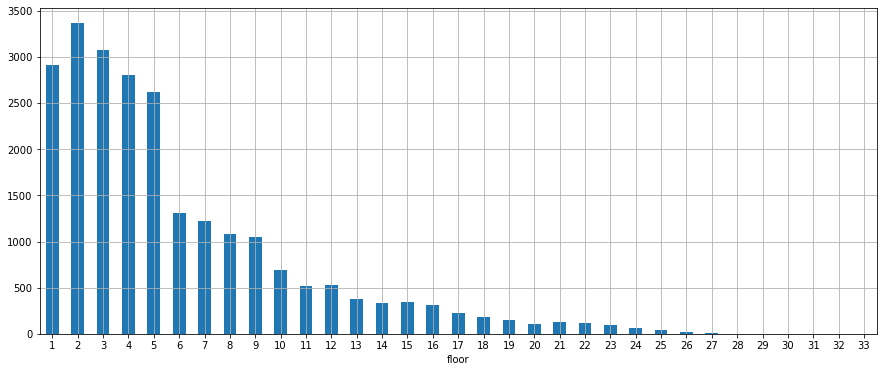

In [47]:
data.groupby('floor')['last_price'].count().plot.bar(rot=0, grid=True, figsize=(15, 6))
None

**Вывод:**

С увеличением этажа количество квартир уменьшается, так как уменьшается количество домов такой этажности. Однако на 1 этаже квартир меньше, чем на 2, хотя первый этаж присутствует в любом доме. Это может быть связано с тем, что на первых этажах много коммерческих помещений.

Более 60% квартир находятся на 1-5 этажах, затем на графике наболюдается резкий спад. Возможно, это связано с популярностью 4-5 этажных домов.

##### Тип этажа квартиры

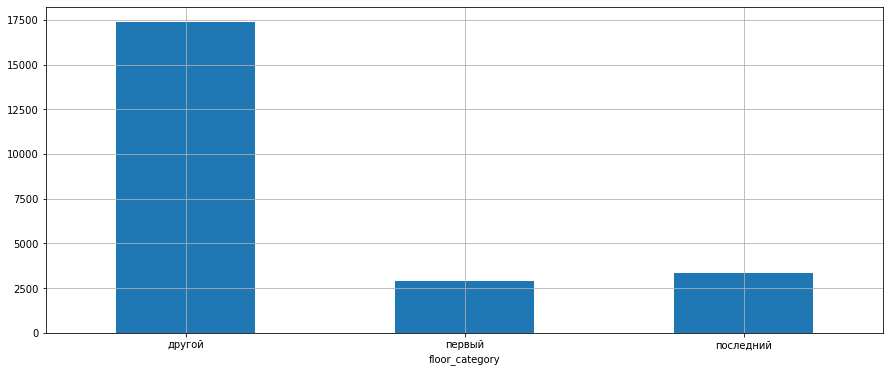

In [48]:
data.groupby('floor_category')['last_price'].count().plot.bar(rot=0, grid=True, figsize=(15, 6))
None

**Вывод:**

Около 70% квартир находятся на этаже, отличном от первого. Квартир на первом этаже немного меньше, чем на последнем.

##### Расстояние до центра города

In [49]:
data['cityCenters_nearest'].describe()

count    18180.000000
mean        14.184818
std          8.616194
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: cityCenters_nearest, dtype: float64

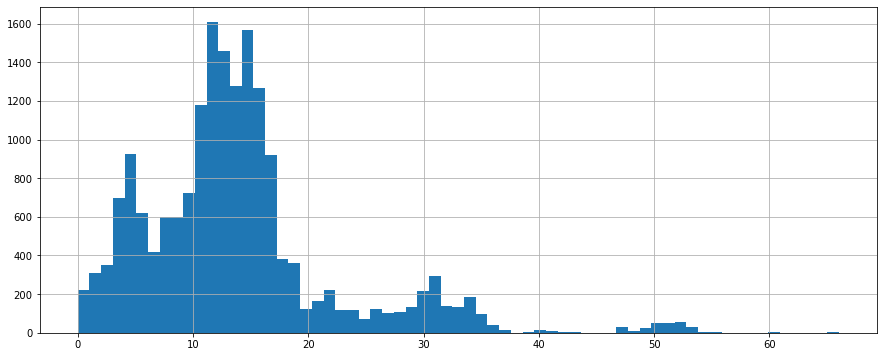

In [50]:
data['cityCenters_nearest'].hist(bins=65, figsize=(15, 6))
None

**Вывод:**

График распределения удаленности от центра неравномерен, так как в графике учитывается несколько населенных пунктов, и для каждого из них будет свое распределение. Даже в рамках одного города могут чередоваться жилые и нежилые зоны, что приведет к неравномерному распределению удаленности от его центра. Также, скорее всего, доминирующим распределением станет распределение по г. Санкт-Петербург, так как в нем больше всего объектов.

##### Расстояние до ближайшего аэропорта

In [51]:
data['airports_nearest'].describe()

count    18157.000000
mean        28.793672
std         12.630881
min          0.000000
25%         18.585000
50%         26.726000
75%         37.273000
max         84.869000
Name: airports_nearest, dtype: float64

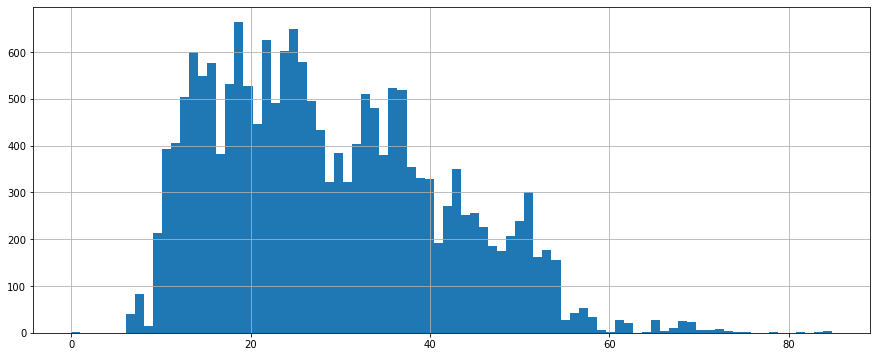

In [52]:
data['airports_nearest'].hist(bins=84, figsize=(15, 6))
None

**Вывод:**

В Ленинградской области только 1 аэропорт, поэтому в общем большая часть объектов находится в радиусе 60 км от него. Однако распределние неравномерное, что связано с концентрацией квартир в населенных пунктах. 

##### Расстояние до ближайшего парка

In [53]:
data['parks_nearest'].describe()

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

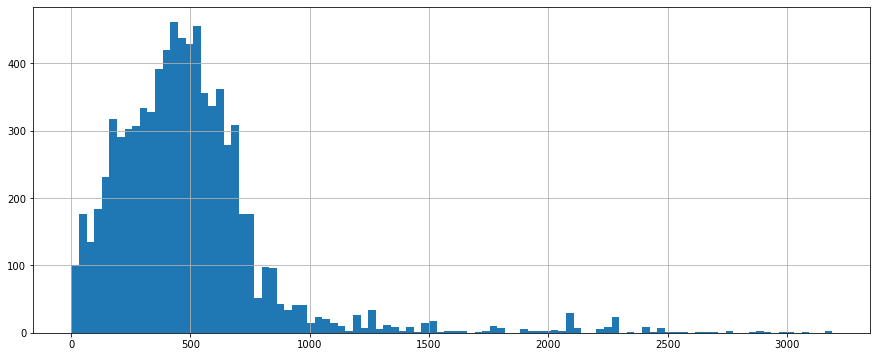

In [54]:
data['parks_nearest'].hist(bins=100, figsize=(15, 6))
None

**Вывод:**

Большая часть объектов находится в пределах 1 км, в среднем объекты находятся в 490 м от парка.

##### День и месяц публикации объявления

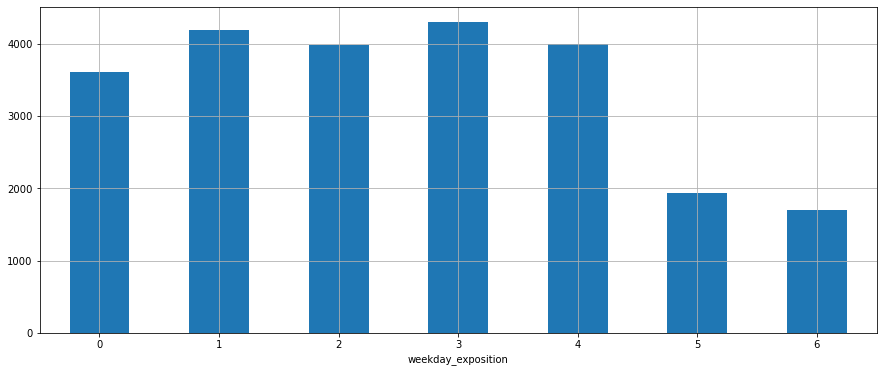

In [55]:
data.groupby('weekday_exposition')['last_price'].count().plot.bar(rot=0, grid=True, figsize=(15, 6))
None

**Вывод:**

В будни объявления выставляются чаще, чем в выходные, вторник и четверг являются самыми популярными днями. Понедельник, наоборот, наименее активный день среди будней.

Чтобы правильно оценить распределение по месяцам, необходимо выделить полные года. Оценим даты в базе:

In [56]:
print('Первое объявление', data['first_day_exposition'].min().strftime('%m/%d/%Y'))
print('Последнее объявление', data['first_day_exposition'].max().strftime('%m/%d/%Y'))

Первое объявление 11/27/2014
Последнее объявление 05/03/2019


Для исследования возьмем данные за 2015-2018 год:

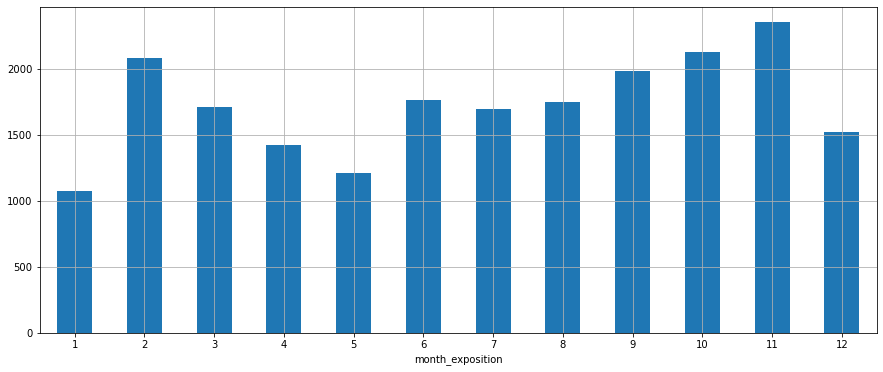

In [57]:
whole_years_data = data[(data['year_exposition'] >= 2015) & (data['year_exposition'] <= 2018)]
whole_years_data.groupby('month_exposition')['last_price'].count().plot.bar(rot=0, grid=True, figsize=(15, 6))
None

**Вывод:**


Месяцы с самыми низкими показателями - январь и май. Вероятно, это связано с большим количеством праздничных дней. В летние месяцы опубликовано примерно одинаковое количество объявлений. Затем начинается рост активности до ноября, и в ноябре опубликовано наибольшее количество объявлений среди всех месяцев. В декабре и январе виден сильный спад количества объявлений, что, возможно, связано с Новым годом. В феврале активность восстанавливается, и продолжает падать до мая.

#### Исследование скорости продажи квартир

In [58]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

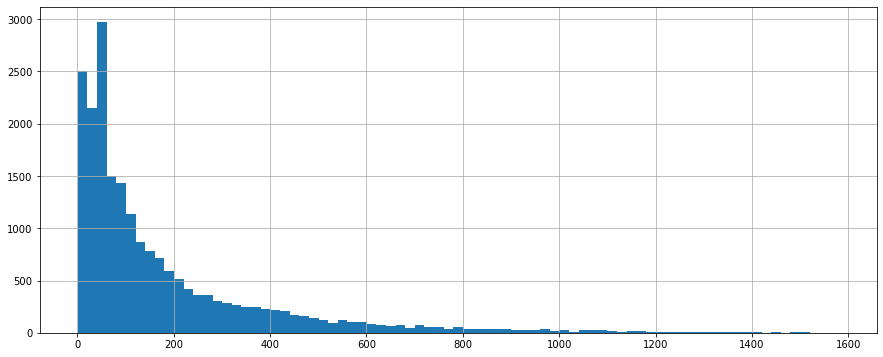

In [59]:
data['days_exposition'].hist(bins=79, figsize=(15, 6))
None

Наблюдается дополнительный пик в районе основного. Рассмотрим данные в пределах года более подробно:

<AxesSubplot:>

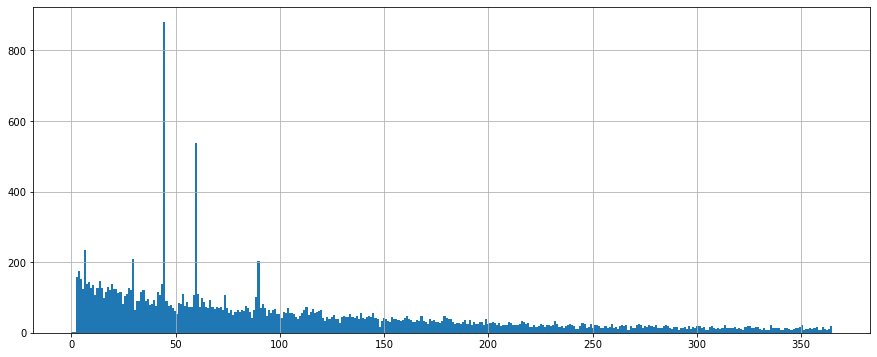

In [60]:
data['days_exposition'].hist(bins=364, range=(0, 365), figsize=(15, 6))

In [61]:
data['days_exposition'].value_counts().head()

45.0    880
60.0    538
7.0     234
30.0    208
90.0    204
Name: days_exposition, dtype: int64

Присутствуют неожиданные выбросы на значениях 7, 30, 45, 60 и 90 дней. Вероятно, они соответствуют автоматическому снятию публикации сервиса, а не продаже квартиры. Отфильтруем данные:

In [62]:
outcomes = data['days_exposition'].value_counts()[:5].index.tolist()
filtered_data = data.query('days_exposition not in @outcomes')

<AxesSubplot:>

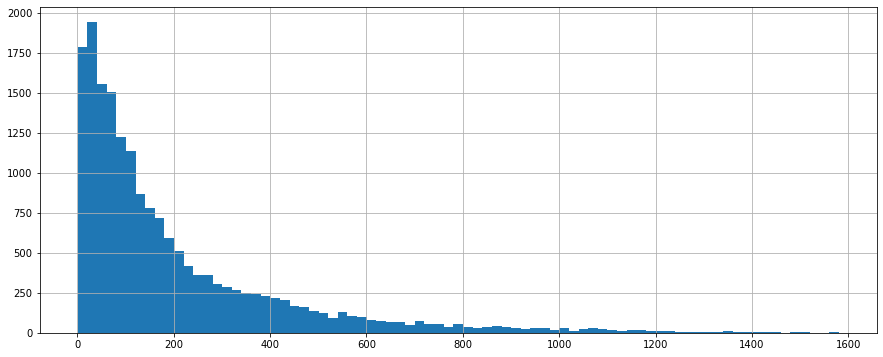

In [63]:
filtered_data['days_exposition'].hist(bins=79, figsize=(15, 6))

Гистограмма демонстрирует пуассоново распределение. 

**Вывод:**

В среднем квартиры продаются в течение ~ 6 месяцев. Половина квартир продается менее чем за 3 месяца. Есть объекты, продаваемые и больше года, наибольшее значение 1580 дней, т.е. более 4 лет. Можно считать продажи, длящиеся более 1 года, необычайно долгими.

#### Исследование факторов, влияющих на стоимость

Для исследования обозначим верхнюю планку стоимости, чтобы "элитные" квартиры не искажали данные для большинства квартир:

In [64]:
filtered_data = data.query('last_price <= 12_000_000').reset_index()

In [65]:
round(len(filtered_data) / total_length, 2)

0.92

Ограничив наибольшую цену 12 млн, мы отбросили менее 10% объектов.

##### Зависимость стоимости от площади

**a. Зависимость от общей площади**

Подготовим данные для исследования. Чтобы избавиться от шума, округлим значения общей площади.

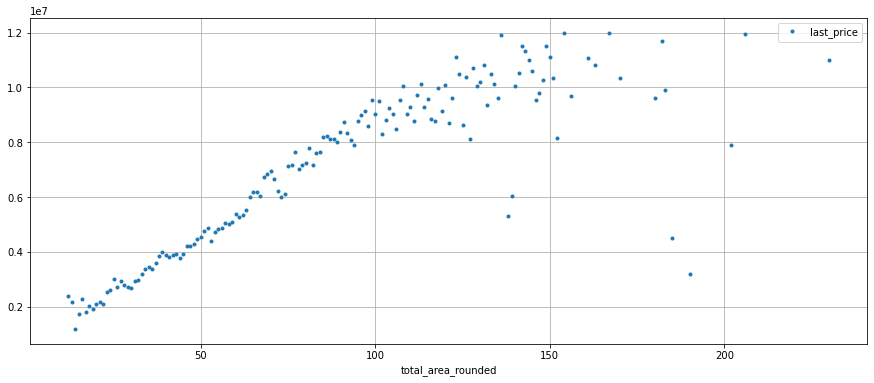

In [66]:
filtered_data['total_area_rounded'] = filtered_data['total_area'].apply('round') #округление до целого
pivot_data = pd.pivot_table(filtered_data, index='total_area_rounded', values='last_price', aggfunc='mean')
pivot_data.plot(style='.', grid=True, figsize=(15, 6))
None

In [67]:
filtered_data['total_area'].corr(filtered_data['last_price'])

0.7046730708813418

Более 95% квартир имеют площадь до 120 кв.м. Для них справедлива практически прямопропорциональня зависимость стоимости от площади, высокий коэффициент корреляции - 0.7.  Далее данные демонстрируют большой разброс, однако в целом тренд сохраняется.

**б. Зависимость от жилой площади**

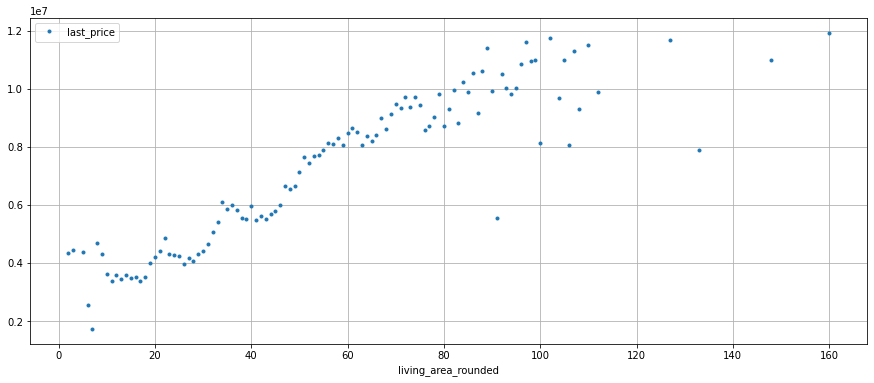

In [68]:
filtered_data['living_area_rounded'] = filtered_data['living_area'].apply('round') #округление до целого
pivot_data = pd.pivot_table(filtered_data, index='living_area_rounded', values='last_price', aggfunc='mean')
pivot_data.plot(style='.', grid=True, figsize=(15, 6))
None

In [69]:
filtered_data['living_area'].corr(filtered_data['last_price'])

0.591571030273589

В общем цена квартиры увеличивается при увеличении жилой площади. Однако присутствуют локальные пики, так как на цену влияет и количество комнат. Есть заметная корреляция, коэффициент корреляции равен 0.59, но он меньше, чем коэффициент для общей площади. 

**в. Зависимость от площади кухни**

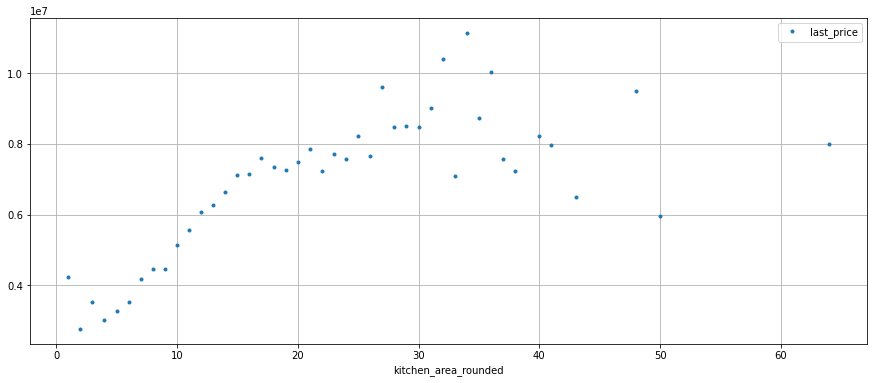

In [70]:
filtered_data['kitchen_area_rounded'] = filtered_data['kitchen_area'].apply('round') #округление до целого
pivot_data = pd.pivot_table(filtered_data, index='kitchen_area_rounded', values='last_price', aggfunc='mean')
pivot_data.plot(style='.', grid=True, figsize=(15, 6))
None

In [71]:
filtered_data['kitchen_area'].corr(filtered_data['last_price'])

0.46689305222451144

Площадь кухни имеет положительную корреляцию со стоимостью квартиры, однако общая и жилая площадь оказывают более сильное влияние.

##### Зависимость стоимости от количества комнат

Логично, что при увеличении количества комнат увеличивается и площадь квартиры, поэтому ожидается, что и стоимость будет увеличиваться. Для исследования зависимости стоимости используем квартиры с не более, чем 6 комнатами, так как далее данных мало, чтобы получить достоверные оценки.

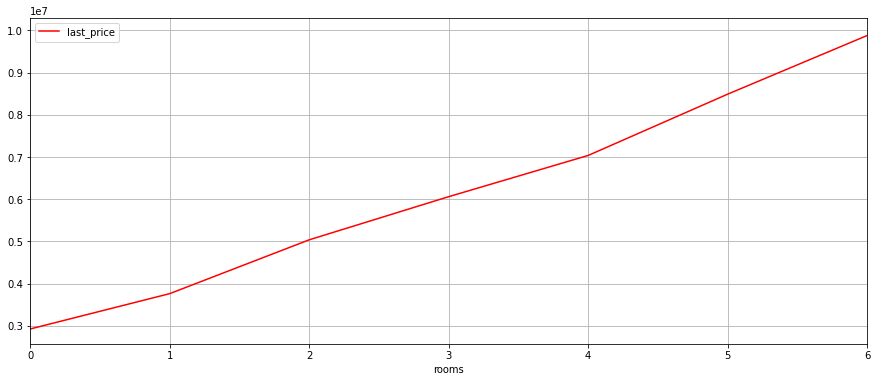

In [72]:
pivot_data = pd.pivot_table(filtered_data, index='rooms', values='last_price', aggfunc='mean')
ax = pivot_data.plot(style='-', color='r', grid=True, xlim=(0, 6), figsize=(15, 6))
None

Средняя стоимость квартиры увеличивается при увеличении количества комнат.

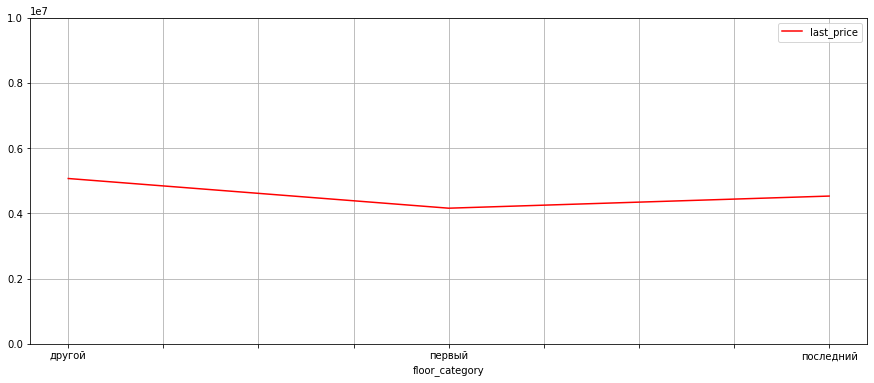

In [73]:
pivot_data = pd.pivot_table(filtered_data, index='floor_category', values='last_price', aggfunc='mean')
pivot_data.plot(style='-', color='r', ylim=(0, 10e6), grid=True, figsize=(15, 6))
None

In [74]:
pivot_data

,last_price
floor_category,
другой,5.070769e+06
первый,4.160474e+06
последний,4.532217e+06


Квартиры на первом и последних этажах в среднем дешевле квартир на других этажах.

##### Зависимость стоимости от даты публикации

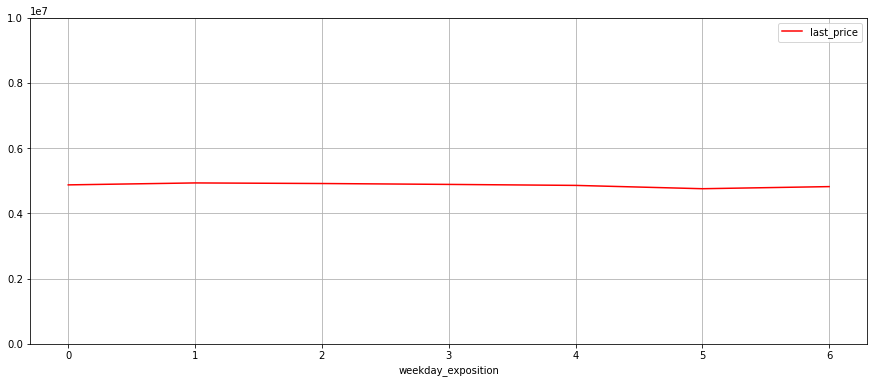

In [75]:
pivot_data = pd.pivot_table(filtered_data, index='weekday_exposition', values='last_price', aggfunc='mean')
pivot_data.plot(style='-', color='r', ylim=(0, 10e6), grid=True, figsize=(15, 6))
None

День недели, в который было размещено объявление, не влияет на стоимость объекта.

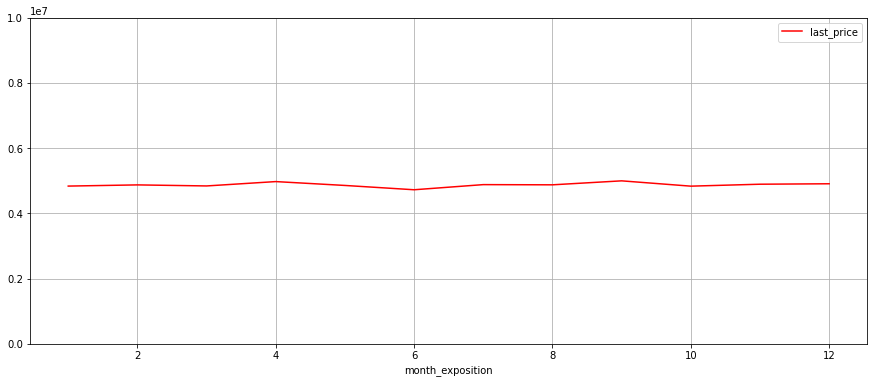

In [76]:
pivot_data = pd.pivot_table(filtered_data, index='month_exposition', values='last_price', aggfunc='mean')
pivot_data.plot(style='-', color='r', ylim=(0, 10e6), grid=True, figsize=(15, 6))
None

Месяц публикации не влияет на стоимость квартиры.

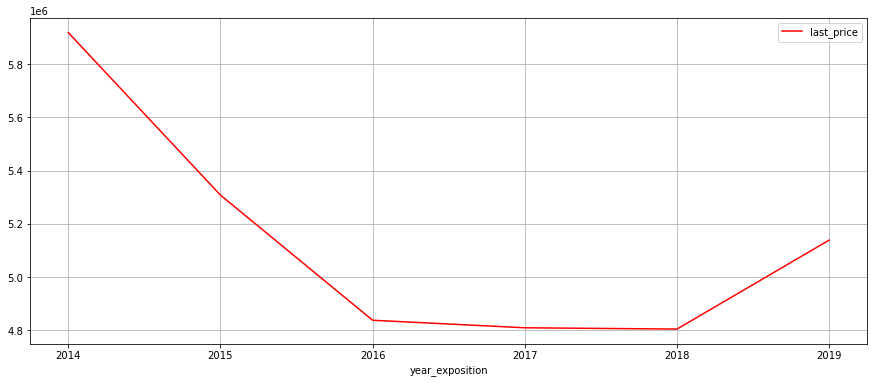

In [77]:
pivot_data = pd.pivot_table(filtered_data, index='year_exposition', values='last_price', aggfunc='mean')
pivot_data.plot(style='-', color='r', grid=True, figsize=(15, 6))
None

В течение 2014-2016 было падение стоимости квартир, 2016-2018 год продемонстрировали относительно стабильную стоимость квартир, а в 2019 цены увеличились.

**Вывод:**
В целом нет разницы, в какой именно день и месяц опубликовано объявление. Поскольку редко квартиры продаются дольше года, изменение цен от года к году, как правило, не имеют вляния на конкретный объект.

#### Исследование средней цены одного квадратного метра

Определим населенные пункты с наибольшим количеством объявлений:

In [78]:
data['locality_name'].value_counts()[:10]

Санкт-Петербург    15721
п. Мурино            556
п. Шушары            440
Всеволожск           398
Пушкин               369
Колпино              338
п. Парголово         327
Гатчина              307
д. Кудрово           299
Выборг               237
Name: locality_name, dtype: int64

Определим среднюю стоимость за 1 кв.м в этих городах:

In [79]:
popular_cities = data['locality_name'].value_counts()[:10].index.tolist()# список из 10 городов
filtered_data = data.query('locality_name in @popular_cities')#данные только из этих городов

pivot_data = pd.pivot_table(filtered_data, index='locality_name', values='price_per_square_meter', aggfunc='mean').round()\
.sort_values(by='price_per_square_meter', ascending=False)
pivot_data

,price_per_square_meter
locality_name,
Санкт-Петербург,114849.0
Пушкин,103126.0
д. Кудрово,92474.0
п. Парголово,90176.0
п. Мурино,85682.0
п. Шушары,78677.0
Колпино,75425.0
Гатчина,68746.0
Всеволожск,68654.0


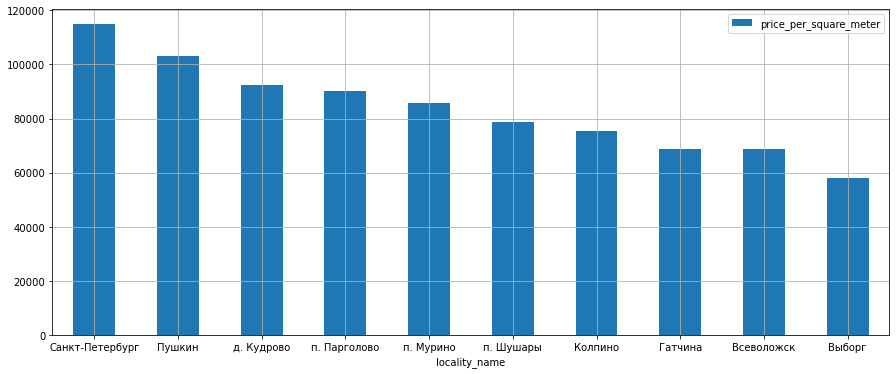

In [80]:
pivot_data.plot.bar(rot=0, grid=True, figsize=(15, 6))
None

Наибольшая стоимость за 1 кв.м. в Санкт-Петербурге, наименьшая - в Выборге.

Исследуем зависимость стоимости квартиры от удаленности от центра.

<AxesSubplot:xlabel='cityCenters_nearest'>

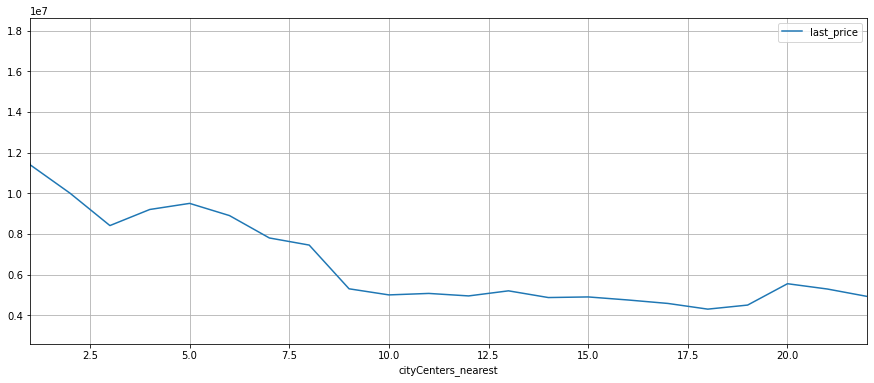

In [81]:
filtered_data = data.query('locality_name == "Санкт-Петербург"')
pivot_data = pd.pivot_table(filtered_data, index='cityCenters_nearest', values='last_price', aggfunc='median')
pivot_data.plot(style='-', xlim=(1, 22), grid=True, figsize=(15, 6))

По мере удаления от центра цена квартир падает. Присутствуют локальный минимум в районе 3 км от центра и небольшой всплеск в районе 20 км от центра. В районе 8-18 км цена меняется совсем немного.

### Общий вывод

О каждой квартире в базе содержится два типа данных: добавленные пользователем и картографические. Например, к первому типу относятся площадь квартиры, её этаж и количество балконов, ко второму — расстояния до центра города, аэропорта и ближайшего парка. Часть данных отсутствует. Были заполнены пропуски в следующих столбцах:

 *   `living_area` - пропущенные значения были посчитаны как доля от общей
 *   `is_apartment` - пропущенные значения заменены на *False*
 *   `kitchen_area` - пропуски заменены средним значением
 *   `balcony` - пропуски заменены на 0
 *   `locality_name` -  - пропуски заменены на *'unknown'*

Для остальных данных логичную замену предложить невозможно, поэтому эти значения остались пустыми. Так же была проведена замена типа данных при необходимости. 

Все данные проверены на аномальные значения. Большие значения высоты потолков `ceiling_height` были пересчитаны.

В названиях населенных пунктов были обнаружены дубликаты, например, `поселок Рябово`/`посёлок Рябово`. Была произведена замена слов, обозначающих тип населенных пунктов на общепринятые сокращения.

Дополнительно в таблицу добавлены новые столбцы со следующими параметрами:
- `price_per_square_meter` - цена одного квадратного метра
- `weekday_exposition` - день недели публикации объявления
- `month_exposition` - месяц публикации объявления
- `month_exposition` - год публикации объявления
- `floor_category` - тип этажа квартиры («первый», «последний», «другой»)


Рассмотрены следующие параметры объектов:
 - *общая площадь*   
    Средняя площадь квартир - 60 кв.м. Большая часть квартир имеет площадь от 20 до 100 кв.м. Более 95% квартир имеют площадь до 120 кв.м.
   
   
 - *жилая площадь*   
    Среднее значение жилой площади - 34 кв.м, однако распределение жилой площади квартир отличается от распределения Пуассона, так как сильно зависит от количества комнат:
    - Средняя жилая площадь 1-комнатных квартир: 18.0 кв.м.
    - Средняя жилая площадь 2-комнатных квартир: 31.84 кв.м.
    - Средняя жилая площадь 3-комнатных квартир: 47.68 кв.м


- *площадь кухни*   
     Размеры кухни мало зависят от других параметров квартир, в среднем площадь кухни равна 10 кв.м, и большая часть кухонь имеет площадь менее 20 кв.м. Есть умеренная корреляция между стоимостью и площадью кухни.
     

- *количество комнат*   
     Самые популярные квартиры - 1, 2 и 3-комнатные, они составляют более 90% от всех объектов. Квартир с количеством комнат более 7 практически нет, единичные случаи. Средняя стоимость квартиры увеличивается при увеличении количества комнат.
          

- *высота потолков*   
     У большинства квартир высота потолков не превышает 5 м. Распределение отличается от пуассоновского, присутствуют пики на значениях 2.5 м, 2.6 м и 3 м.
     
     

- *этаж квартиры и тип этажа квартиры («первый», «последний», «другой»)*   
    С увеличением этажа количество квартир уменьшается, так как уменьшается количество домов такой этажности. Однако на 1 этаже квартир меньше, чем на 2, хотя первый этаж присутствует в любом доме. Более 60% квартир находятся на 1-5 этажах. Около 70% квартир находятся на этаже, отличном от первого. Квартир на первом этаже немного меньше, чем на последнем. 
     

- *расстояние до центра города*   
     График распределения удаленности от центра неравномерен, так как в учитываются несколько населенных пунктов, и для каждого из них будет свое распределение.
     

- *расстояние до ближайшего аэропорта*   
     В Ленинградской области только 1 аэропорт, поэтому в общем большая часть объектов находится в радиусе 60 км от него.


- расстояние до ближайшего парка   
     Большая часть объектов находится в пределах 1 км от парков, в среднем объекты находятся в 490 м.
     

- *день и месяц публикации объявления*   
    В будни объявления выставляются чаще, чем в выходные, вторник и четверг являются самыми активными днями. В понедельник, наоборот, активность наименьшая среди будней.
    Месяцы с самыми низкой активностью - январь и май. В летние месяцы опубликовано примерно одинаковое количество объявлений. Затем начинается рост активности до ноября, и в ноябре опубликовано наибольшее количество объявлений среди всех месяцев. В декабре и январе виден сильный спад количества объявлений. В феврале активность восстанавливается, и продолжает падать до мая.

Были исследованы сроки продаж квартир. В среднем квартиры продаются в течение ~ 6 месяцев. Половина квартир продается менее чем за 3 месяца. Есть объекты, продаваемые и больше года, наибольшее значение 1580 дней, т.е. более 4 лет. Можно считать продажи, длящиеся более 1 года, необычайно долгими.


Было исследовано, как стоимость объектов зависит от:

- *общей площади*  
    Присутствует практически прямопропорциональня зависимость стоимости от площади, высокий коэффициент корреляции 0.7.


- *жилой площади*  
    В общем цена квартиры увеличивается при увеличении жилой площади. Коэффициент корреляции 0.59.


- *площади кухни*  
    Площадь кухни имеет положительную корреляцию со стоимостью квартиры, однако общая и жилая площадь оказывают более сильное влияние. Коэффициент корреляции 0.47.


- *количества комнат*  
    Средняя стоимость квартир увеличивается при увеличении количества комнат.


- *этажа, на котором расположена квартира (первый, последний, другой)*  
    Квартиры на первом и последних этажах в среднем дешевле квартир на других этажах. 


- *даты размещения (день недели, месяц, год)*  
    Данные не показывают зависимости стоимости от того, в какой именно день и месяц опубликовано объявление. Поскольку редко квартиры продаются дольше года, изменение цен от года к году, как правило, так же не имеют вляния на конкретный объект.

Была определена средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений: 
Санкт-Петербург, Пушкин, д. Кудрово, п. Парголово, п. Мурино, п. Шушары, Колпино, Гатчина, Всеволожск и Выборг. Наибольшая цена в Санкт-Петербурге - 114849 р./кв.м, наименьшая в Выборге - 58142 р./кв.м.

Для Санкт-Петербурга рассмотрено изменение медианной стоимости квартир от местоположения. По мере удаления от центра цена квартир падает. Присутствуют локальный минимум в районе 3 км от центра и небольшой всплеск в районе 20 км от центра. В районе 8-18 км цена меняется совсем немного.